# Modelos de Linguagem com LSTM

Este notebook introduz os **Modelos de Linguagem** (*Language Models*), uma das aplicações mais fundamentais e poderosas do processamento de linguagem natural. Exploraremos a teoria matemática por trás desses modelos e implementaremos uma versão prática usando **Long Short-Term Memory (LSTM)** networks com PyTorch.

## Conteúdos Abordados

1. **Fundamentos Teóricos de Modelos de Linguagem**: A matemática da modelagem probabilística da linguagem
2. **Long Short-Term Memory (LSTM)**: Arquitetura avançada para sequências longas
3. **Implementação de um Modelo de Linguagem com LSTM**: Construção completa do pipeline
4. **Geração Autorregressiva**: Como gerar texto de forma probabilística
5. **Análise de Perplexidade**: Métrica de avaliação de modelos de linguagem
6. **Análise dos Embeddings Aprendidos**: Visualização do espaço semântico

## 1. Fundamentos Teóricos de Modelos de Linguagem

Um **modelo de linguagem** é um modelo probabilístico que atribui probabilidades a sequências de palavras. Formalmente, dado um vocabulário $V$ e uma sequência de palavras $w_1, w_2, \ldots, w_T$, um modelo de linguagem estima a probabilidade conjunta:

$$P(w_1, w_2, \ldots, w_T)$$

### Decomposição Autorregressiva

Pela regra da cadeia da probabilidade, podemos decompor essa probabilidade conjunta como:

$$P(w_1, w_2, \ldots, w_T) = \prod_{t=1}^{T} P(w_t | w_1, w_2, \ldots, w_{t-1})$$

Onde $P(w_t | w_1, \ldots, w_{t-1})$ é a **probabilidade condicional** da palavra $w_t$ dado todo o contexto anterior. Esta decomposição é chamada de **autorregressiva** porque cada palavra é modelada condicionalmente em relação às palavras anteriores.

### O Problema da Maldição da Dimensionalidade

Estimar $P(w_t | w_1, \ldots, w_{t-1})$ diretamente é impraticável, pois:
1. O número de possíveis contextos cresce exponencialmente com o comprimento
2. A maioria das sequências específicas nunca aparece nos dados de treino

### Aproximação Neural

Modelos neurais de linguagem resolvem este problema aprendendo uma função paramétrica $f_\theta$:

$$P(w_t | w_1, \ldots, w_{t-1}) \approx f_\theta(w_1, \ldots, w_{t-1})$$

Onde $\theta$ representa os parâmetros da rede neural (pesos e biases).

## 2. Long Short-Term Memory (LSTM)

Enquanto RNNs tradicionais sofrem do problema de **desvanecimento do gradiente** (*vanishing gradient*), as **LSTMs** foram projetadas especificamente para capturar dependências de longo prazo em sequências.

### Arquitetura da Célula LSTM

Uma célula LSTM possui três **gates** (portões) que controlam o fluxo de informação:

1. **Forget Gate** ($f_t$): Decide quanta informação descartar do estado da célula
2. **Input Gate** ($i_t$): Decide quais valores atualizar no estado da célula
3. **Output Gate** ($o_t$): Controla quais partes do estado da célula serão outputadas

### Equações Matemáticas da LSTM

Para o tempo $t$, com entrada $x_t$ e estado oculto anterior $h_{t-1}$:

**Gates:**
$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$

**Candidato a novo estado:**
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

**Estado da célula:**
$$C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$$

**Estado oculto:**
$$h_t = o_t * \tanh(C_t)$$

Onde $\sigma$ é a função sigmoid, $*$ denota multiplicação elemento-a-elemento, e $W$, $b$ são as matrizes de pesos e vetores de bias, respectivamente.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
from collections import Counter
import math

## 3. Preparação dos Dados

Para treinar nosso modelo de linguagem, utilizaremos um corpus de texto em português. O processo de preparação envolve:

1. **Limpeza e tokenização** do texto
2. **Construção do vocabulário** com as palavras mais frequentes
3. **Criação de sequências** de treinamento com janela deslizante
4. **Mapeamento** de tokens para índices numéricos

In [ ]:
# Corpus expandido em português sobre inteligência artificial
corpus_text = """
Inteligência artificial generativa ou IA generativa é um ramo da inteligência artificial focado na criação de conteúdo novo, baseado em padrões identificados nos conjuntos de dados de treinamento. É possível criar conteúdo como texto, imagens, áudio, vídeo, código de software, podendo ser gerados a partir de pedidos (ou prompts) em linguagem natural, ou até através de imagens para imagens, e de vídeos para vídeos.[1][2][3] Essa forma de visualizar esses modelos é uma categorização baseado em formato de entrada e saída, de texto para texto (text-to-text), texto para imagem (text-to-image), entre vários outros.[4]

Sistemas de IA generativa incluem Stable Diffusion e DALL-E, modelos de imagens de inteligência artificial,[5][6][7] assim como modelos de texto como o ChatGPT, um chatbot construído pela OpenAI usando os modelos de linguagem de grande escala GPT-3 e GPT-4,[8] Bard, um chatbot construído pelo Google usando o modelo LaMDA,[9] e o Microsoft Copilot , chatbot construído pela Microsoft que é uma extensão do modelo de linguagem GPT-4 da OpenAI e que foi pensada para uso vinculado aos serviços da Microsoft e sistema operacional Windows.

IA generativa tem aplicações potenciais numa ampla gama de setores[10], incluindo desenvolvimento de software, marketing e moda.[11][12] O investimento em IA generativa aumentou durante o início da década de 2020, com grandes empresas como Microsoft, Google e Baidu, bem como várias outras empresas menores a desenvolver modelos de IA generativa.[1][13][14] E a Nvidia foi uma das empresas que mais cresceram nesse meio tempo, uma vez que começou a utilizar suas GPUs para o treinamento de grandes modelos de linguagem cada vez mais poderosos.[15]

Na saúde, a IA generativa também tem transformado e impactado significativamente o cuidado ao paciente, educação em saúde e pesquisas na área. As oportunidades de desenvolvimento são grandes, no entanto, há desafios éticos que precisam ser considerados.[16]

Como um exemplo das aplicações da IA generativa, tem-se a transformação no campo da medicina, onde essa tecnologia tem expandido suas possibilidades, alterando a maneira como o cuidado é prestado, as funções dos profissionais de saúde e a comunicação entre pacientes e médicos. Além disso, a IA generativa tem mostrado grande potencial na melhoria da descoberta científica, como em ensaios clínicos e pesquisas observacionais, além de contribuir para a educação médica. Esses avanços são resultado do aprimoramento técnico da IA, que agora é capaz de gerar linguagem e imagens realistas, gerando discussões sobre a melhor forma de integrar esses modelos no contexto médico.[17]

Na informática, a Inteligência Artificial (abreviado IA) genericamente é a inteligência, o raciocínio e o aprendizado exibida por máquinas semelhante ao raciocino humano;[1][2] busca desenvolver máquinas autônomas ou sistemas especialistas capazes de simular o pensamento humano e realizar várias tarefas complexas de forma independente.[3][4][5][6][7] É o sistema que permite aos computadores executar funções avançadas, como a capacidade de analisar dados em grande escala e fazer previsões/recomendações;[1][8] É um campo de pesquisa em ciência da computação que desenvolve e estuda métodos e softwares que permitem que as máquinas percebam seu ambiente e usem o aprendizado e a inteligência para tomar ações que maximizem suas chances de atingir objetivos definidos.[9] A IA iniciou na década de 1950 com os pesquisadores Alan Turing e Herbert Simon baseado no conceito do filósofo grego Aristóteles.

Em 1950, o matemático inglês Allan Turing escreveu sobre ser possível uma máquina pensar, e imitar o comportamento humano inteligente.[10] Também esboçou uma proposta de pesquisa para tornar isto possível.

Aplicações de IA incluem mecanismos avançados de busca na web (por exemplo, Google Search); sistemas de recomendação (usados pelo YouTube, Amazon e Netflix); assistentes virtuais (por exemplo, Google Assistant, Siri e Alexa ); veículos autônomos (por exemplo, Waymo); ferramentas generativas e criativas (por exemplo, ChatGPT, DeepSeek e AI art); e jogo e análise sobre-humanos em jogos de estratégia (por exemplo, xadrez e Go). No entanto, muitas aplicações de IA não são percebidas como IA porque já se tornaram comuns o suficiente no cotidiano das pessoas.[11][12] Como por exemplo, o reconhecimento óptico de caracteres (OCR) que extrai o texto de imagens; transforma conteúdo não estruturado em dados estruturados com insights prontos para negócios;[1] tradução de textos em idiomas estrangeiros e tradução de voz.[8]

A IA é um campo que abrange muitas disciplinas, como: ciência da computação, estatísticas, engenharia de hardware e de software, linguística, neurociência e, filosofia.[1] Vários subcampos da pesquisa em IA são centrados em objetivos específicos e no uso de ferramentas específicas. Os objetivos tradicionais da pesquisa em IA incluem raciocínio, representação de conhecimento, planejamento, aprendizagem, processamento de linguagem natural, percepção e suporte à robótica. A inteligência geral — a capacidade de completar qualquer tarefa realizada por um humano em um nível pelo menos igual — está entre os objetivos de longo prazo do campo.[13] Para atingir esses objetivos, os pesquisadores de IA adaptaram e integraram uma ampla gama de técnicas, incluindo otimização matemática e de busca, lógica formal, redes neurais artificiais e métodos baseados em estatística, pesquisa operacional e economia. A IA também se baseia na psicologia, linguística, filosofia, neurociência e em outros campos.[14]

A inteligência artificial foi fundada como disciplina acadêmica em 1956[15] e o campo passou por múltiplos ciclos de otimismo ao longo de sua história,[16] seguidos por períodos de decepção e perda de financiamento. Os recursos e o interesse aumentaram enormemente após 2012, quando a aprendizagem profunda superou as técnicas de IA anteriores. Este crescimento acelerou ainda mais depois de 2017[17] e no início da década de 2020 muitos milhares de milhões de dólares estavam a ser investidos em IA e o campo experimentou um rápido progresso contínuo no que ficou conhecido como o boom da IA. O surgimento da IA generativa avançada e sua capacidade de criar e modificar conteúdo expôs diversas consequências e danos não intencionais no presente e levantou preocupações sobre os riscos da IA e seus efeitos de longo prazo no futuro, gerando discussões sobre políticas regulatórias para garantir a segurança e os benefícios da tecnologia.
"""

print(f"Tamanho do corpus: {len(corpus_text)} caracteres")
print(f"Primeiros 200 caracteres:")
print(corpus_text[:200])

Tamanho do corpus: 6527 caracteres
Primeiros 200 caracteres:

Inteligência artificial generativa ou IA generativa é um ramo da inteligência artificial focado na criação de conteúdo novo, baseado em padrões identificados nos conjuntos de dados de treinamento. É 


In [ ]:
def preprocess_text(text):
    """Limpa e tokeniza o texto."""
    # Converter para minúsculas e remover caracteres especiais
    text = text.lower()
    text = re.sub(r'[^a-záàâãéèêíìîóòôõúùûç\s]', '', text)

    # Tokenizar por palavras
    tokens = text.split()

    return tokens

def build_vocabulary(tokens, vocab_size=1000):
    """Constrói vocabulário com as palavras mais frequentes."""
    counter = Counter(tokens)

    # Tokens especiais
    special_tokens = ['<UNK>', '<START>', '<END>']

    # Palavras mais frequentes (excluindo tokens especiais)
    frequent_words = [word for word, _ in counter.most_common(vocab_size - len(special_tokens))]

    # Vocabulário completo
    vocabulary = special_tokens + frequent_words

    # Mapeamentos
    word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    return vocabulary, word_to_idx, idx_to_word

# Processar o corpus
tokens = preprocess_text(corpus_text)
vocabulary, word_to_idx, idx_to_word = build_vocabulary(tokens, vocab_size=200)

print(f"Total de tokens: {len(tokens)}")
print(f"Vocabulário único: {len(vocabulary)}")
print(f"Primeiras 20 palavras do vocabulário: {vocabulary[:20]}")

Total de tokens: 963
Vocabulário único: 200
Primeiras 20 palavras do vocabulário: ['<UNK>', '<START>', '<END>', 'de', 'e', 'ia', 'a', 'o', 'em', 'da', 'como', 'que', 'para', 'no', 'generativa', 'é', 'por', 'um', 'inteligência', 'na']


In [ ]:
def encode_tokens(tokens, word_to_idx):
    """Converte tokens em índices numéricos."""
    unk_idx = word_to_idx['<UNK>']
    return [word_to_idx.get(token, unk_idx) for token in tokens]

def create_training_sequences(encoded_tokens, seq_length):
    """Cria sequências de entrada e alvos para treinamento."""
    sequences = []
    targets = []

    for i in range(len(encoded_tokens) - seq_length):
        seq = encoded_tokens[i:i + seq_length]
        target = encoded_tokens[i + seq_length]
        sequences.append(seq)
        targets.append(target)

    return sequences, targets

# Codificar tokens
encoded_tokens = encode_tokens(tokens, word_to_idx)

# Criar sequências de treinamento
seq_length = 10  # Comprimento da sequência de contexto
sequences, targets = create_training_sequences(encoded_tokens, seq_length)

print(f"Número total de sequências de treinamento: {len(sequences)}")
print(f"Exemplo de sequência: {sequences[0]}")
print(f"Alvo correspondente: {targets[0]}")

# Decodificar para verificar
example_seq_words = [idx_to_word[idx] for idx in sequences[0]]
example_target_word = idx_to_word[targets[0]]
print(f"Sequência em palavras: {example_seq_words}")
print(f"Alvo em palavra: {example_target_word}")

Número total de sequências de treinamento: 953
Exemplo de sequência: [18, 28, 14, 31, 5, 14, 15, 17, 126, 9]
Alvo correspondente: 18
Sequência em palavras: ['inteligência', 'artificial', 'generativa', 'ou', 'ia', 'generativa', 'é', 'um', 'ramo', 'da']
Alvo em palavra: inteligência


## 4. Dataset Personalizado para PyTorch

Criaremos uma classe Dataset personalizada para facilitar o carregamento dos dados em lotes (*batches*) durante o treinamento.

In [ ]:
class LanguageModelDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.LongTensor(self.sequences[idx]),
            torch.LongTensor([self.targets[idx]])
        )

# Criar dataset e dataloader
dataset = LanguageModelDataset(sequences, targets)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Dataset criado com {len(dataset)} exemplos")
print(f"Número de lotes: {len(dataloader)}")

# Testar um lote
for batch_seq, batch_target in dataloader:
    print(f"Formato do lote de sequências: {batch_seq.shape}")
    print(f"Formato do lote de alvos: {batch_target.shape}")
    break

Dataset criado com 953 exemplos
Número de lotes: 30
Formato do lote de sequências: torch.Size([32, 10])
Formato do lote de alvos: torch.Size([32, 1])


## 5. Implementação do Modelo de Linguagem com LSTM

Nossa arquitetura consistirá em:

1. **Camada de Embedding**: Converte índices de palavras em vetores densos
2. **Camada LSTM**: Processa a sequência e mantém memória de longo prazo
3. **Camada Linear de Saída**: Projeta do espaço oculto para o vocabulário
4. **Dropout**: Regularização para prevenir overfitting

A saída final são **logits** sobre todo o vocabulário, que são convertidos em probabilidades via **softmax**.

In [ ]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.3):
        super(LSTMLanguageModel, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.vocab_size = vocab_size

        # Camadas da rede
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        """
        Forward pass do modelo.

        Args:
            x: tensor de entrada [batch_size, seq_length]
            hidden: estado oculto inicial (opcional)

        Returns:
            output: logits sobre vocabulário [batch_size, seq_length, vocab_size]
            hidden: estado oculto final
        """
        batch_size = x.size(0)

        # Embedding: [batch_size, seq_length] -> [batch_size, seq_length, embedding_dim]
        embedded = self.embedding(x)

        # LSTM: [batch_size, seq_length, embedding_dim] -> [batch_size, seq_length, hidden_dim]
        lstm_out, hidden = self.lstm(embedded, hidden)

        # Dropout para regularização
        lstm_out = self.dropout(lstm_out)

        # Projeção para vocabulário: [batch_size, seq_length, hidden_dim] -> [batch_size, seq_length, vocab_size]
        output = self.fc_out(lstm_out)

        return output, hidden

    def init_hidden(self, batch_size, device):
        """Inicializa estado oculto com zeros."""
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))

# Hiperparâmetros do modelo
vocab_size = len(vocabulary)
embedding_dim = 64 # [32, 64, 128, 256]
hidden_dim = 128 # [64, 128, 256, 512]
num_layers = 2
dropout = 0.3

# Instanciar modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMLanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout)
model = model.to(device)

print(f"Modelo criado com {sum(p.numel() for p in model.parameters())} parâmetros")
print(f"Dispositivo: {device}")
print(model)

Modelo criado com 270024 parâmetros
Dispositivo: cpu
LSTMLanguageModel(
  (embedding): Embedding(200, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=128, out_features=200, bias=True)
)


## 6. Treinamento do Modelo

O treinamento de um modelo de linguagem usa **Cross-Entropy Loss** entre as probabilidades preditas e as palavras reais. A cada época, passamos todas as sequências pelo modelo e atualizamos os parâmetros via **backpropagation**.

### Função de Loss

Para uma sequência de entrada $x_1, \ldots, x_T$ e alvo $y$, a loss é:

$$\mathcal{L} = -\log P(y | x_1, \ldots, x_T) = -\log \frac{\exp(\text{logit}_y)}{\sum_{i=1}^{|V|} \exp(\text{logit}_i)}$$

In [ ]:
# Configuração de treinamento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

# Lista para armazenar perdas
training_losses = []

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Treina o modelo por uma época."""
    model.train()
    total_loss = 0.0
    num_batches = 0

    for batch_seq, batch_target in dataloader:
        batch_seq = batch_seq.to(device)
        batch_target = batch_target.squeeze(-1).to(device)  # Remove dimensão extra

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output, _ = model(batch_seq)

        # Pegar apenas o último token de saída para cada sequência
        # output shape: [batch_size, seq_length, vocab_size]
        # Queremos: [batch_size, vocab_size]
        last_output = output[:, -1, :]

        # Calcular loss
        loss = criterion(last_output, batch_target)

        # Backward pass
        loss.backward()

        # Gradient clipping (importante para LSTMs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Atualizar parâmetros
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

print("Iniciando treinamento...")

for epoch in tqdm(range(num_epochs)):
    epoch_loss = train_epoch(model, dataloader, criterion, optimizer, device)
    training_losses.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Época [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Treinamento concluído!")

Iniciando treinamento...


  0%|          | 0/50 [00:00<?, ?it/s]

Época [10/50], Loss: 3.5691
Época [20/50], Loss: 2.8269
Época [30/50], Loss: 2.0559
Época [40/50], Loss: 1.4807
Época [50/50], Loss: 1.0140
Treinamento concluído!


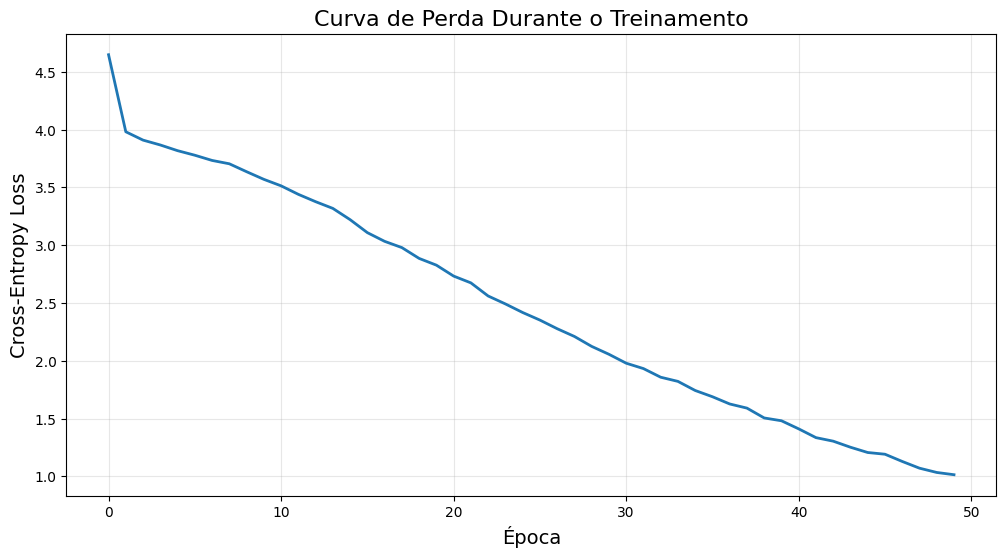

Perda inicial: 4.6471
Perda final: 1.0140
Redução: 78.2%


In [ ]:
# Visualizar curva de perda
plt.figure(figsize=(12, 6))
plt.plot(training_losses, linewidth=2)
plt.title('Curva de Perda Durante o Treinamento', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.ylabel('Cross-Entropy Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Perda inicial: {training_losses[0]:.4f}")
print(f"Perda final: {training_losses[-1]:.4f}")
print(f"Redução: {((training_losses[0] - training_losses[-1]) / training_losses[0] * 100):.1f}%")

## 7. Geração Autorregressiva de Texto

Agora implementaremos a **geração autorregressiva**, onde o modelo gera texto palavra por palavra, usando suas próprias predições anteriores como entrada para as próximas predições.

### Processo de Geração

1. Começamos com uma sequência *seed* (semente)
2. O modelo prediz a próxima palavra mais provável
3. Adicionamos essa palavra à sequência
4. Repetimos o processo usando a nova sequência como entrada

### Estratégias de Amostragem

- **Greedy**: Sempre escolher a palavra mais provável
- **Random Sampling**: Amostrar aleatoriamente da distribuição de probabilidade
- **Temperature Sampling**: Controlar a "criatividade" com um parâmetro de temperatura

In [ ]:
def generate_text(model, seed_text, max_length=50, temperature=1.0, device='cpu'):
    """
    Gera texto usando o modelo treinado.

    Args:
        model: modelo LSTM treinado
        seed_text: texto inicial (string)
        max_length: número máximo de palavras a gerar
        temperature: controla aleatoriedade (1.0 = normal, >1.0 = mais criativo, <1.0 = mais conservador)
        device: dispositivo (cpu ou cuda)

    Returns:
        texto gerado (string)
    """
    model.eval()

    # Tokenizar e codificar texto seed
    seed_tokens = preprocess_text(seed_text)
    if len(seed_tokens) == 0:
        seed_tokens = ['inteligencia']  # Fallback

    # Codificar tokens
    seed_indices = encode_tokens(seed_tokens, word_to_idx)

    # Garantir que temos pelo menos seq_length tokens
    if len(seed_indices) < seq_length:
        # Pad com tokens <START>
        start_idx = word_to_idx['<START>']
        seed_indices = [start_idx] * (seq_length - len(seed_indices)) + seed_indices
    else:
        # Usar apenas os últimos seq_length tokens
        seed_indices = seed_indices[-seq_length:]

    generated_indices = seed_indices.copy()
    current_sequence = seed_indices.copy()

    with torch.no_grad():
        for _ in range(max_length):
            # Converter para tensor
            input_tensor = torch.LongTensor([current_sequence]).to(device)

            # Forward pass
            output, _ = model(input_tensor)

            # Pegar logits da última posição
            last_logits = output[0, -1, :]

            # Aplicar temperature
            if temperature != 1.0:
                last_logits = last_logits / temperature

            # Converter para probabilidades
            probabilities = F.softmax(last_logits, dim=0)

            # Amostrar próxima palavra
            if temperature == 0.0:  # Greedy
                next_token_idx = torch.argmax(probabilities).item()
            else:  # Sampling
                next_token_idx = torch.multinomial(probabilities, 1).item()

            # Parar se gerar token de fim
            if next_token_idx == word_to_idx.get('<END>', -1):
                break

            # Adicionar nova palavra
            generated_indices.append(next_token_idx)

            # Atualizar sequência atual (janela deslizante)
            current_sequence = current_sequence[1:] + [next_token_idx]

    # Decodificar de volta para texto
    generated_words = []
    for idx in generated_indices:
        word = idx_to_word.get(idx, '<UNK>')
        if word not in ['<START>', '<END>', '<UNK>']:
            generated_words.append(word)

    return ' '.join(generated_words)

# Testar geração com diferentes seeds e temperaturas
seeds = [
    "inteligencia artificial",
    "aprendizado de maquina",
    "redes neurais"
]

temperatures = [0.5, 1.0, 1.5]

print("=== EXEMPLOS DE GERAÇÃO DE TEXTO ===")
print()

for seed in seeds:
    print(f"Seed: '{seed}'")
    print("-" * 50)

    for temp in temperatures:
        generated_text = generate_text(model, seed, max_length=30, temperature=temp, device=device)
        print(f"Temperature {temp}: {generated_text}")

    print()


=== EXEMPLOS DE GERAÇÃO DE TEXTO ===

Seed: 'inteligencia artificial'
--------------------------------------------------
Temperature 0.5: artificial de linguagem de treinamento e e e o para chatbot construído construído é que modelos modelos de modelos de grande os conteúdo e gpt um um chatbot dados esses modelos
Temperature 1.0: artificial de de possível como esses como e para atingir copilot saúde construído modelos ao imagens os treinamento de e texttotext e e e forma humano que que
Temperature 1.5: artificial linguagem o saída de educação novo vídeos e serviços chatgpt construído pela um usando modelo modelos uma modelos e possível conjuntos das aplicações ia modelos são gama em raciocínio campo

Seed: 'aprendizado de maquina'
--------------------------------------------------
Temperature 0.5: aprendizado de de linguagem como e e e o de imagens pela menores menores é a modelos em grande de linguagem grande grande grande para vídeos em imagem entre entre esses
Temperature 1.0: apren

## 8. Avaliação: Perplexidade do Modelo

A **perplexidade** é a métrica padrão para avaliar modelos de linguagem. Ela mede quão "surpreso" o modelo fica com uma sequência de palavras. Matematicamente:

$$\text{Perplexidade} = \exp\left(-\frac{1}{T} \sum_{t=1}^{T} \log P(w_t | w_1, \ldots, w_{t-1})\right)$$

- **Perplexidade menor** = modelo melhor
- **Perplexidade = tamanho do vocabulário** = modelo aleatório
- **Perplexidade = 1** = modelo perfeito (impossível na prática)

In [ ]:
def calculate_perplexity(model, dataloader, device):
    """
    Calcula perplexidade do modelo nos dados de teste.
    """
    model.eval()
    total_loss = 0.0
    num_tokens = 0

    criterion = nn.CrossEntropyLoss(reduction='sum')

    with torch.no_grad():
        for batch_seq, batch_target in dataloader:
            batch_seq = batch_seq.to(device)
            batch_target = batch_target.squeeze(-1).to(device)

            # Forward pass
            output, _ = model(batch_seq)

            # Última saída de cada sequência
            last_output = output[:, -1, :]

            # Calcular loss
            loss = criterion(last_output, batch_target)

            total_loss += loss.item()
            num_tokens += batch_target.size(0)

    # Perplexidade é exp da loss média
    average_loss = total_loss / num_tokens
    perplexity = math.exp(average_loss)

    return perplexity, average_loss

# Calcular perplexidade no conjunto de dados
perplexity, average_loss = calculate_perplexity(model, dataloader, device)

print(f"=== AVALIAÇÃO DO MODELO ===")
print(f"Perda média: {average_loss:.4f}")
print(f"Perplexidade: {perplexity:.2f}")
print(f"Tamanho do vocabulário: {vocab_size}")
print(f"Perplexidade de modelo aleatório: {vocab_size}")
print(f"Melhoria sobre modelo aleatório: {(vocab_size - perplexity):.2f} pontos")

=== AVALIAÇÃO DO MODELO ===
Perda média: 0.7481
Perplexidade: 2.11
Tamanho do vocabulário: 200
Perplexidade de modelo aleatório: 200
Melhoria sobre modelo aleatório: 197.89 pontos


## 9. Análise dos Embeddings Aprendidos

Vamos visualizar os embeddings de palavras que o modelo aprendeu durante o treinamento. Palavras semanticamente similares devem ter embeddings próximos no espaço vetorial.

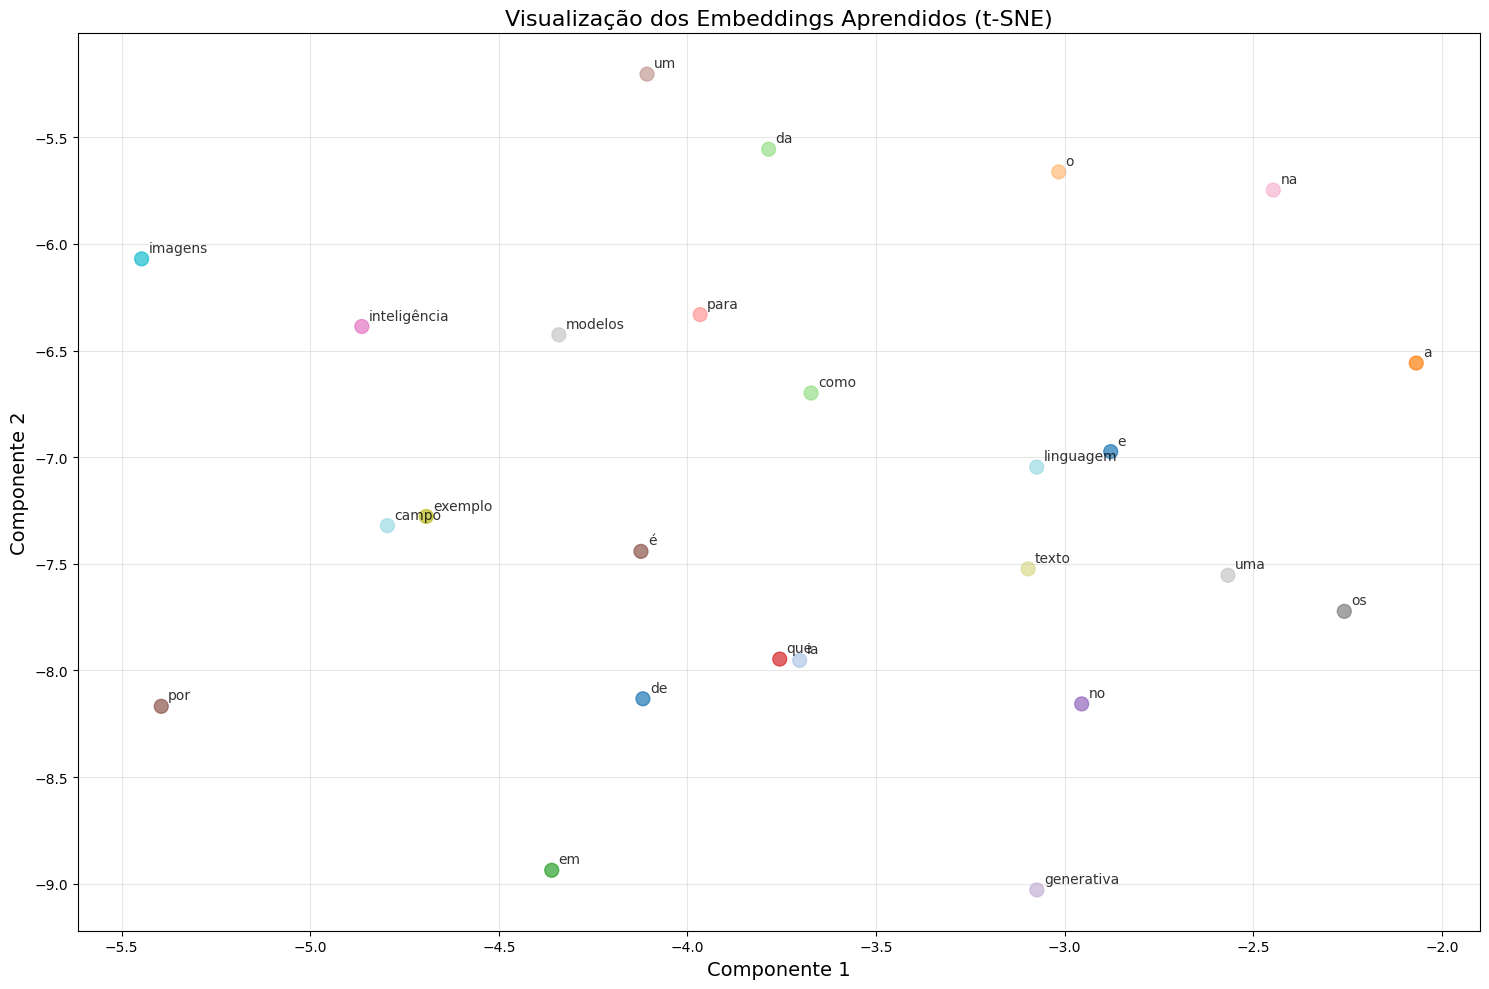

=== PALAVRAS SIMILARES ===

Palavras similares a 'aprendizado':
  computação: 0.330
  aos: 0.325
  lamda: 0.313
  criar: 0.282
  grande: 0.281

Palavras similares a 'dados':
  cresceram: 0.354
  sua: 0.346
  vídeos: 0.314
  tem: 0.261
  durante: 0.235


In [ ]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

def visualize_embeddings(model, vocabulary, word_to_idx, num_words=30):
    """
    Visualiza embeddings usando t-SNE.
    """
    # Extrair embeddings do modelo
    embeddings = model.embedding.weight.data.cpu().numpy()

    # Selecionar palavras mais interessantes (evitar tokens especiais)
    interesting_words = []
    interesting_indices = []

    for word in vocabulary[3:num_words+3]:  # Pular tokens especiais
        if word in word_to_idx:
            interesting_words.append(word)
            interesting_indices.append(word_to_idx[word])

    # Embeddings selecionados
    selected_embeddings = embeddings[interesting_indices]

    # Reduzir dimensionalidade com t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(15, len(interesting_words)-1))
    embeddings_2d = tsne.fit_transform(selected_embeddings)

    # Plotar
    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         alpha=0.7, s=100, c=range(len(interesting_words)),
                         cmap='tab20')

    # Adicionar labels
    for i, word in enumerate(interesting_words):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=10, alpha=0.8)

    plt.title('Visualização dos Embeddings Aprendidos (t-SNE)', fontsize=16)
    plt.xlabel('Componente 1', fontsize=14)
    plt.ylabel('Componente 2', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def find_similar_words(model, word, word_to_idx, idx_to_word, top_k=5):
    """
    Encontra palavras mais similares usando similaridade do cosseno.
    """
    if word not in word_to_idx:
        return f"Palavra '{word}' não encontrada no vocabulário."

    # Embedding da palavra alvo
    word_idx = word_to_idx[word]
    embeddings = model.embedding.weight.data.cpu().numpy()
    word_embedding = embeddings[word_idx].reshape(1, -1)

    # Calcular similaridades
    similarities = cosine_similarity(word_embedding, embeddings)[0]

    # Encontrar índices das palavras mais similares
    similar_indices = np.argsort(similarities)[::-1][1:top_k+1]  # Excluir a própria palavra

    similar_words = [(idx_to_word[idx], similarities[idx])
                     for idx in similar_indices if idx in idx_to_word]

    return similar_words

# Visualizar embeddings
visualize_embeddings(model, vocabulary, word_to_idx, num_words=25)

# Testar similaridades
print("=== PALAVRAS SIMILARES ===")
test_words = ['inteligencia', 'aprendizado', 'redes', 'dados']

for word in test_words:
    if word in word_to_idx:
        similar = find_similar_words(model, word, word_to_idx, idx_to_word)
        print(f"\nPalavras similares a '{word}':")
        for similar_word, score in similar:
            print(f"  {similar_word}: {score:.3f}")


## Exercícios

### Exercício 1: Experimentando com Hiperparâmetros

Modifique os hiperparâmetros (`embedding_dim`, `hidden_dim`, camadas, dropout...) do modelo LSTM e observe como afetam o desempenho.

Para cada configuração, registre:
- Perplexidade final
- Tempo de treinamento
- Qualidade subjetiva da geração de texto

Qual configuração oferece o melhor equilíbrio entre desempenho e eficiência?
* Configurações (embedding_dim, hidden_dim, tempo, perplexidade, redução de perda):
* 256, 512, 1:37, 1.00, 99.9;
* 256, 256, 0:32, 1.02, 99.2;
* 256, 128, 0:13, 1.28, 92.0;
* 128, 512, 1:35, 1.01, 99.8;
* 128, 256, 0:28, 1.05, 98.2;
* 128, 128, 0:11, 1.35, 91.0.
* O melhor equilíbrio foi da segunda configuração, que possui valores muito bons de perplexidade e redução de perda com um tempo bem aceitável, comparando a diferença entre os que fizeram em menos tempo com resultados inferiores e os que tiveram melhores resultados.

### Exercício 2: Expandindo o Corpus

O corpus atual é relativamente pequeno. Sua tarefa é:

1. **Expandir o corpus**: Adicione mais texto sobre IA em português (pode usar artigos da Wikipedia, livros em domínio público, etc.)
2. **Pré-processar adequadamente**: Implemente limpeza mais robusta (remoção de URLs, normalização de acentos, etc.)
3. **Aumentar o vocabulário**: Teste com vocabulários maiores
4. **Retreinar o modelo**: Use o corpus expandido e compare os resultados

Como o tamanho do corpus afeta a qualidade da geração?
* Com um corpus maior a qualidade da geração mehora devido ao amplo repertório e diversidade de possibilidades de geração, tornando o modelo mais natural com um vocabulário mais robusto. Porém o resultado, em comparação com o corpus anterior, não foi muito superior.

### Exercício 3: Implementando Top-k e Nucleus Sampling

A função `generate_text` atual usa apenas temperature sampling. Implemente duas estratégias mais avançadas:

1. **Top-k Sampling**: Considere apenas as k palavras mais prováveis
2. **Top-p Sampling**: Considere o menor conjunto de palavras cuja probabilidade acumulada seja ≥ p

Compare a qualidade da geração entre as diferentes estratégias.